In [1]:
import os
os.getcwd()

'/Users/irenie/Downloads'

'/Users/irenie/Downloads'

In [5]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [6]:
pd.options.display.max_columns=100

In [7]:
df_store=pd.read_csv('archive/stores.csv')

In [8]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
df_train = pd.read_csv('archive/train.csv')

In [10]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [11]:
df_features=pd.read_csv('archive/features.csv')

In [12]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


**Merging 3 different datasets**

In [13]:
df= df_train.merge(df_features, on=['Store','Date'], how='inner'
                  ).merge(df_store, on=['Store'],how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [14]:
#dropping duplicated column
df.drop(['IsHoliday_y'],axis =1,inplace=True)

In [15]:
#Rename the holiday column
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [16]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [17]:
df.shape

(421570, 16)

**Store and Department Numbers**

In [18]:
#Number of different Stores
df['Store'].nunique()

45

In [19]:
#Number of different Departures
df['Dept'].nunique()

81

We will look at the average weekly sales for each store and each department. There are 45 stores and 81 departments for store

In [20]:
store_dept_table = pd.pivot_table(df,index='Store',
                                 columns='Dept',values='Weekly_Sales',aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

From the pivot table, it is seen that there are some wrong values such as minus values for weekly sales. Sales amount can not be minus and it is impossible for 1 department not to sell anything whole week

In [21]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221


1358/421570 rows is about 0.3% so we can delete and ignore these rows which contain wrong sales value

In [22]:
df=df.loc[df['Weekly_Sales']>0]

In [23]:
df.shape

(420212, 16)

## **DATE**

In [24]:
concatenated_dates = pd.concat([df['Date'].head(5), df['Date'].tail(5)], ignore_index=True)

In [25]:
concatenated_dates

0    2010-02-05
1    2010-02-12
2    2010-02-19
3    2010-02-26
4    2010-03-05
5    2012-09-28
6    2012-10-05
7    2012-10-12
8    2012-10-19
9    2012-10-26
Name: Date, dtype: object

our date is from 5th of February 2012 to 26th of October 2012

## **Holiday**

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

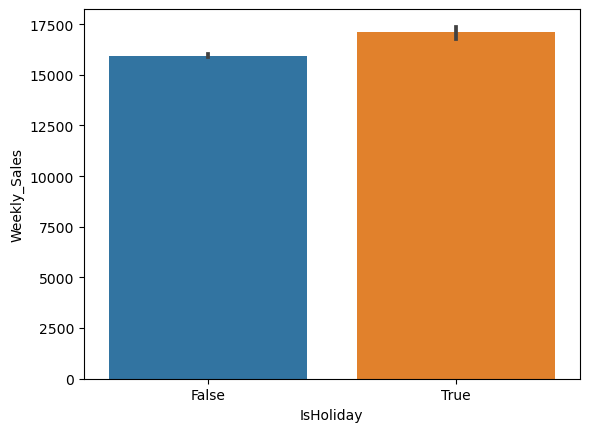

In [26]:
sns.barplot(x='IsHoliday',y='Weekly_Sales',data=df)

In [27]:
df_holiday=df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [28]:
df_not_holiday=df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

All holidays are not in the data

Labor Day: 10-Sep-10, 9-Sep-11,7-Sep-12,6-Sep-13

Thanksgiving: 26-Nov-10,25-Nov-11,23-Nov-12,29-Nov-13

Christmas:31-Dec-10,30-Dec-11,28-Dec-12,27-Dec-13


In [29]:
#Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|
       (df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&
       (df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [30]:
#Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|
       (df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&
       (df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [31]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|
       (df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&
       (df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

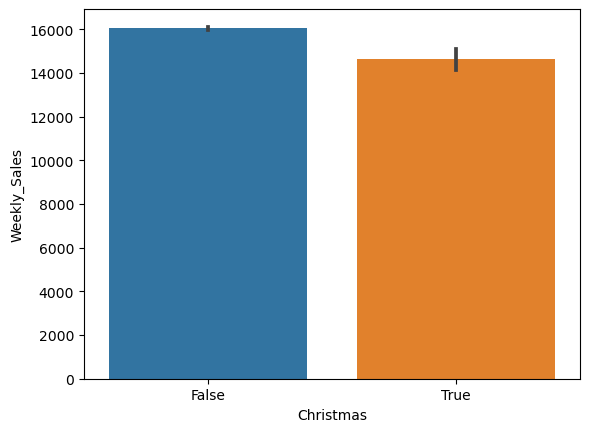

In [32]:
# Christmas holiday vs not-Christmas
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) 

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

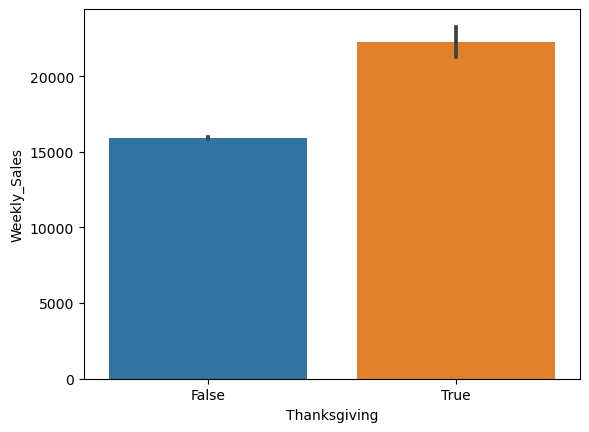

In [33]:
#Thanks giving holiday vs not-thanksgiving
sns.barplot(x='Thanksgiving',y='Weekly_Sales',data=df)

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

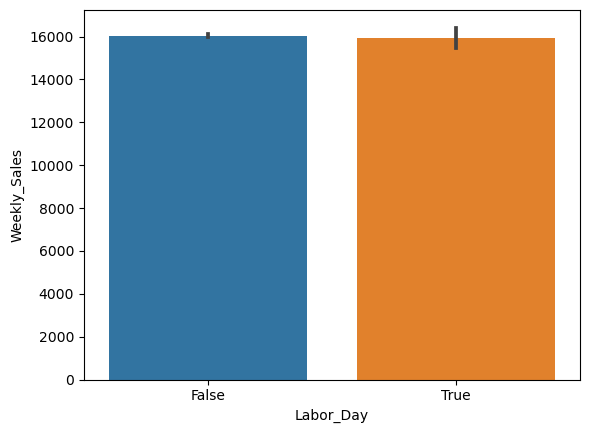

In [34]:
#Labor day holiday vs not-labor day
sns.barplot(x='Labor_Day',y='Weekly_Sales',data=df)

It is shown for the graphs, Labor Day and Christmas do not increase weekly average sales. The highest difference is in Thanksgiving. 
I think people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in Christmas week.

# **Type Effect on Holidays**

There are 3 different store types in the data as A,B and C

In [35]:
#Average weekly sales for types on Christmas
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [36]:
#Average weekly sales for types on Labor Day
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [37]:
#Average weekly sales for types on Thanksgiving
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

## Percentage of store types

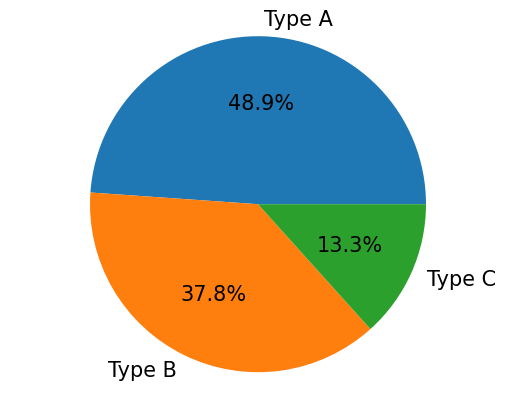

In [38]:
my_data=[48.88,37.77,13.33] #percentage
my_labels = 'Type A','Type B','Type C' #labels
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%',
        textprops={'fontsize':15}) #plot pie type and bigger the labels
plt.axis('equal')

plt.show()

In [39]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

Half of the stores are belongs to Type A

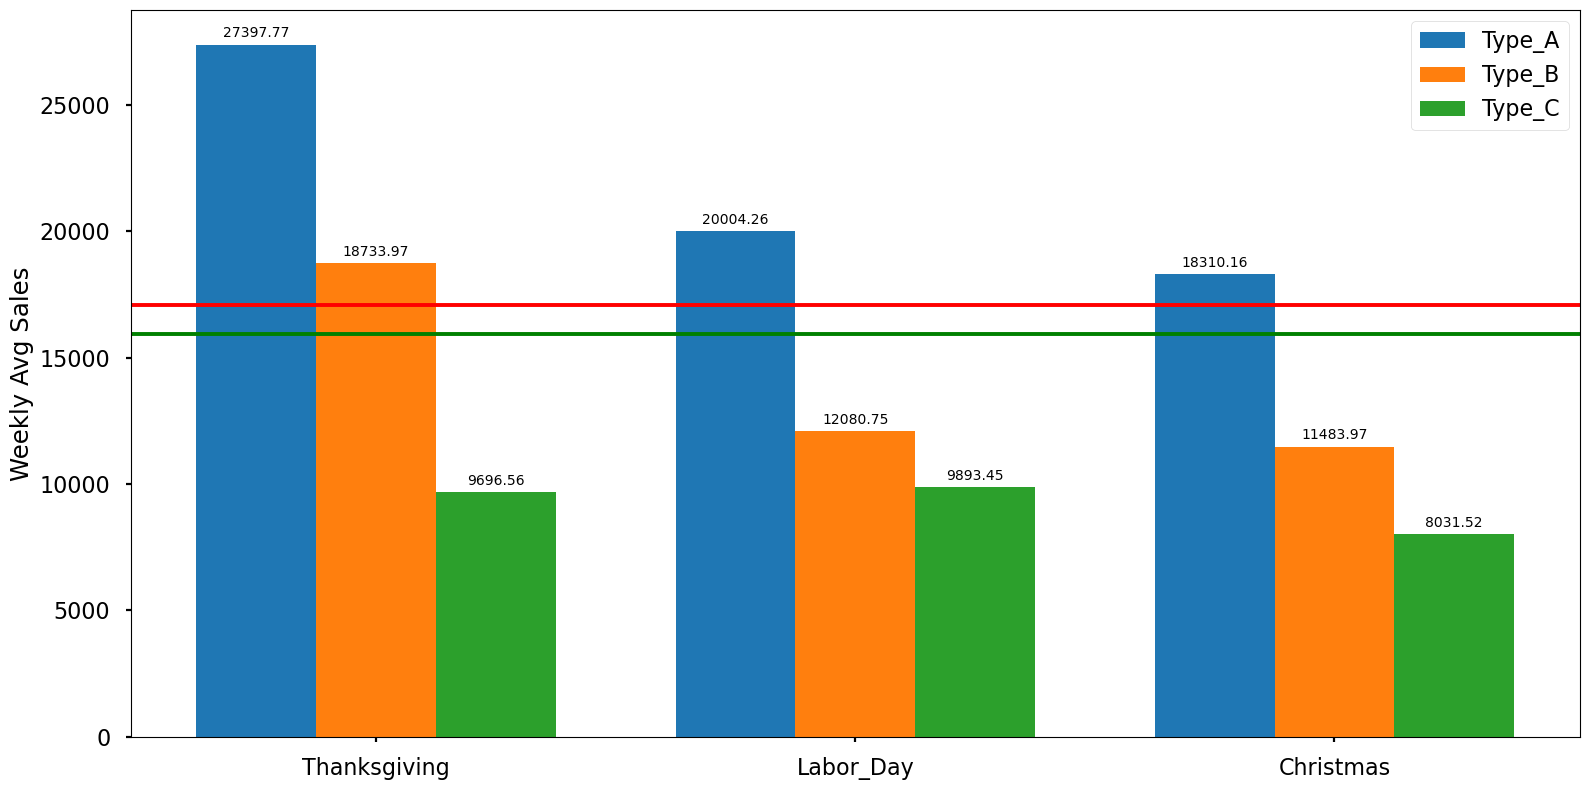

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting avg weekly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Labor_Day', 'Christmas']

A_means = [27397.77, 20004.26, 18310.16]
B_means = [18733.97, 12080.75, 11483.97]
C_means = [9696.56, 9893.45, 8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))  # corrected line
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x, B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30, color='r')  # holidays avg
plt.axhline(y=15952.82, color='green')  # not-holiday avg

fig.tight_layout()

plt.show()

It seems from the graph that, highest sale average is in Thanksgiving week between holidays. And for all holidays Type A stores has highest sales

In [41]:
#top 5 weekly sale
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,True,False
338013,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,True,False
95425,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,True,False
337961,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,True,False
135665,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,True,False


Not surprise that top 5 highest weekly sales are belong to Thanksgiving weeks

## Size-Type of store relation

In [42]:
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


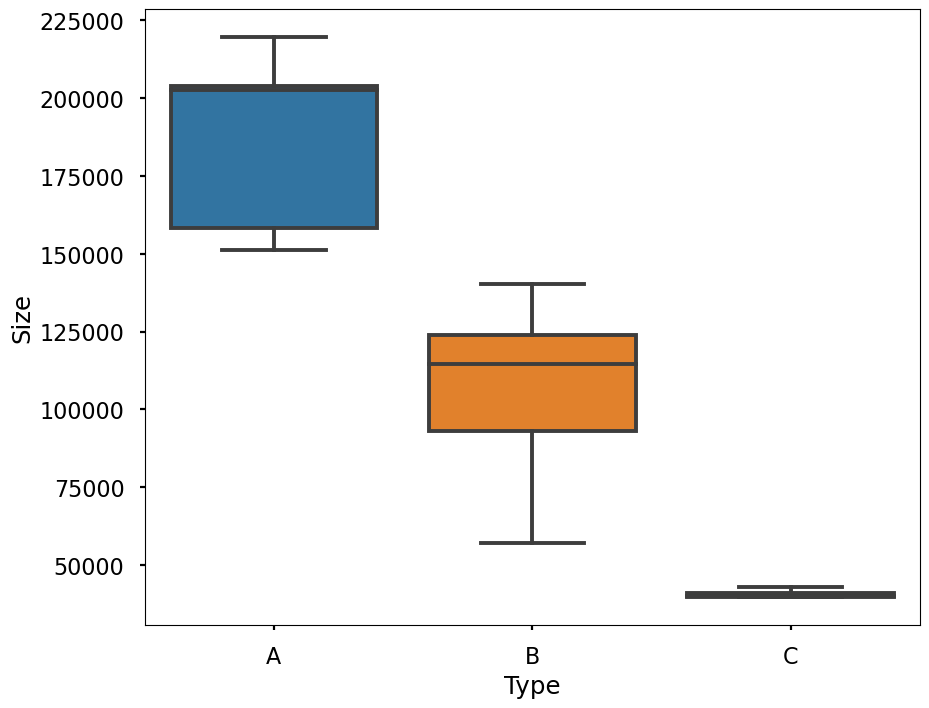

In [43]:
plt.figure(figsize=(10,8))
fig = sns.boxplot(x='Type',y='Size',data=df,showfliers=False)

Size of type of stores are consistent with sales. Higher size stores have higher sales

Walmart classify stores according to their sizes according to graph:
- Smallest size of Type A, largest size of type B begins
- After smallest size value of Type B, largest value of type C begins

## Markdown columns

Walmart gave markdown columns to see the effect if markdowns on sales

In [44]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

There are many null values for markdowns so we decide to change them with 0 so if markdown is 0 means no markdown on that date

In [45]:
df = df.fillna(0)

In [46]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [47]:
df.describe() #statistical check

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Minimum value for weekly sales if 0.01. This value seems to be unrealistic but we will keep it here now

## Changing Date to Datetime and Creating New Columns

In [48]:
df["Date"] = pd.to_datetime(df["Date"])  # Convert to datetime
df['week'] = df['Date'].dt.isocalendar().week  # ISO week number
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

In [49]:
df.groupby('month')['Weekly_Sales'].mean() 

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [50]:
# see the best years for sales
df.groupby('year')['Weekly_Sales'].mean()

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

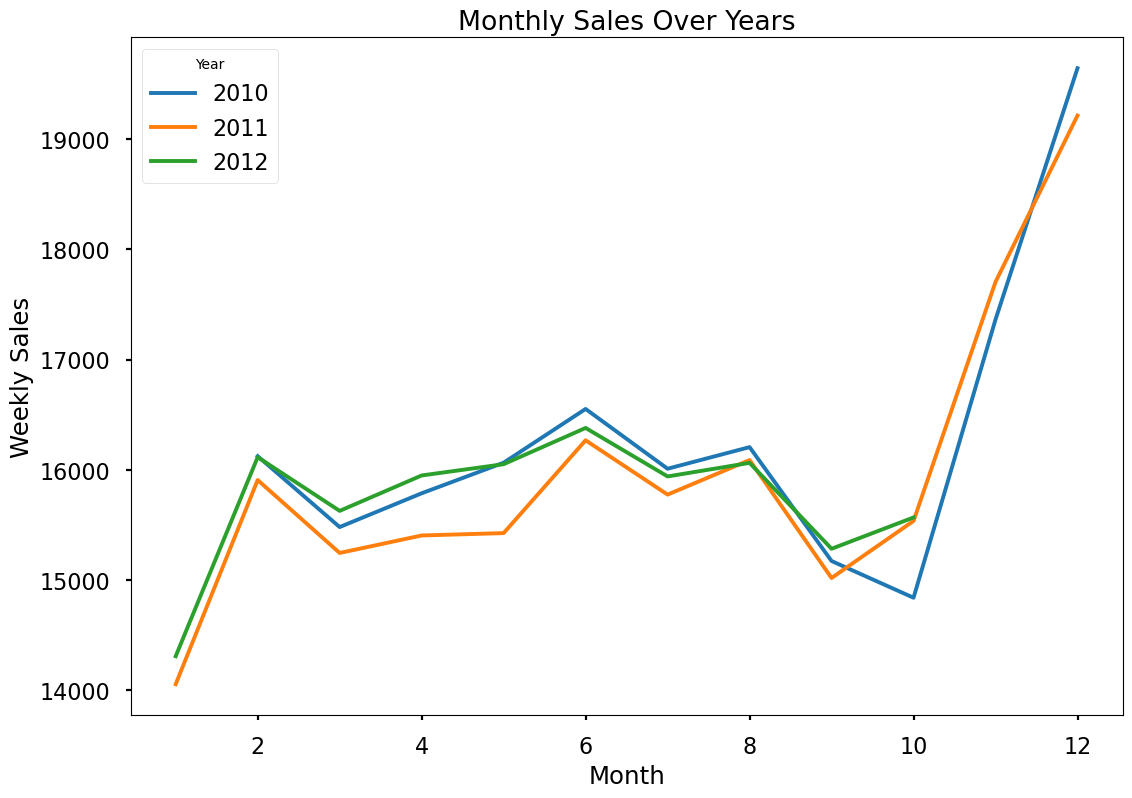

In [51]:
monthly_sales = pd.pivot_table(df, values='Weekly_Sales', columns='year', index='month')
monthly_sales.plot()

plt.xlabel('Month')
plt.ylabel('Weekly Sales')
plt.title('Monthly Sales Over Years')
plt.legend(title='Year', loc='upper left')
plt.show()

As shown in the graph, it is seen that 2011 has lower sales than 2010 generally. It seems that 2010 has highest, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last 2 months sales, its average is near to 2010. Probably, it will take the first place if we get enough 2012 results

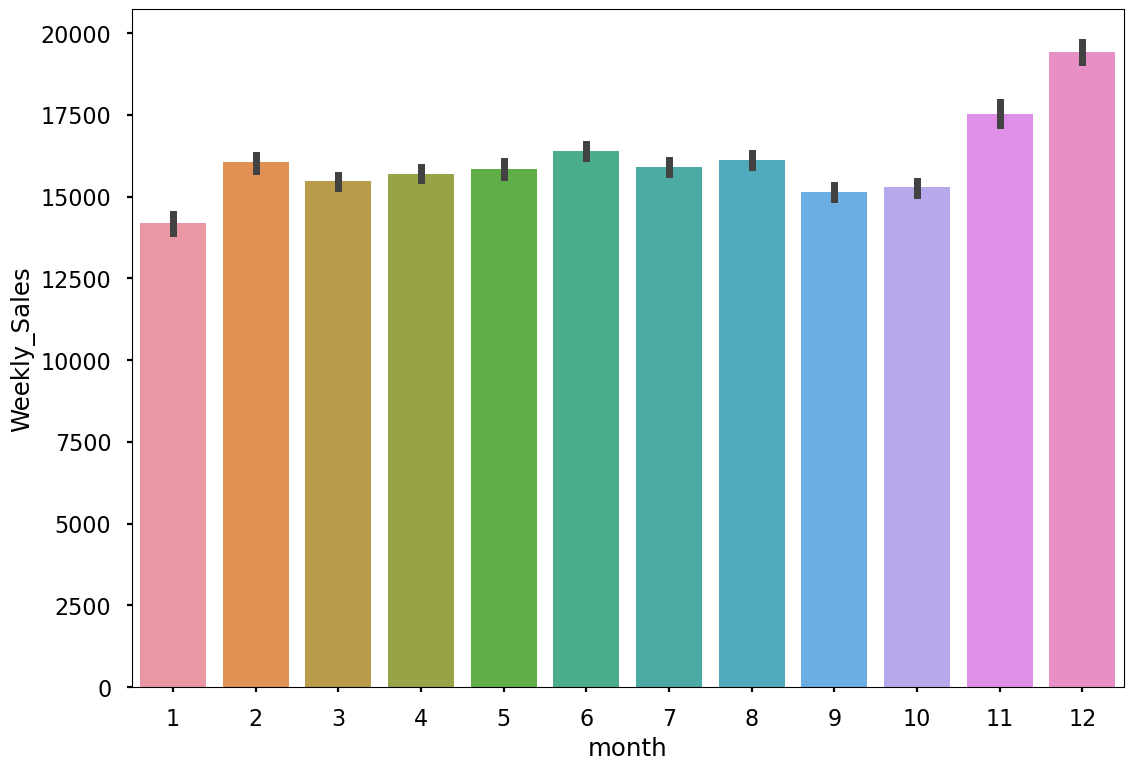

In [52]:
fig = sns.barplot(x='month',y='Weekly_Sales',data=df)

When we look at the graph above, the best sales are in December and November, as expected. the highest values are belong to Thanksgiving holiday but when we take average it is obvious that December has the best value

In [53]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, BlackFriday and end of May

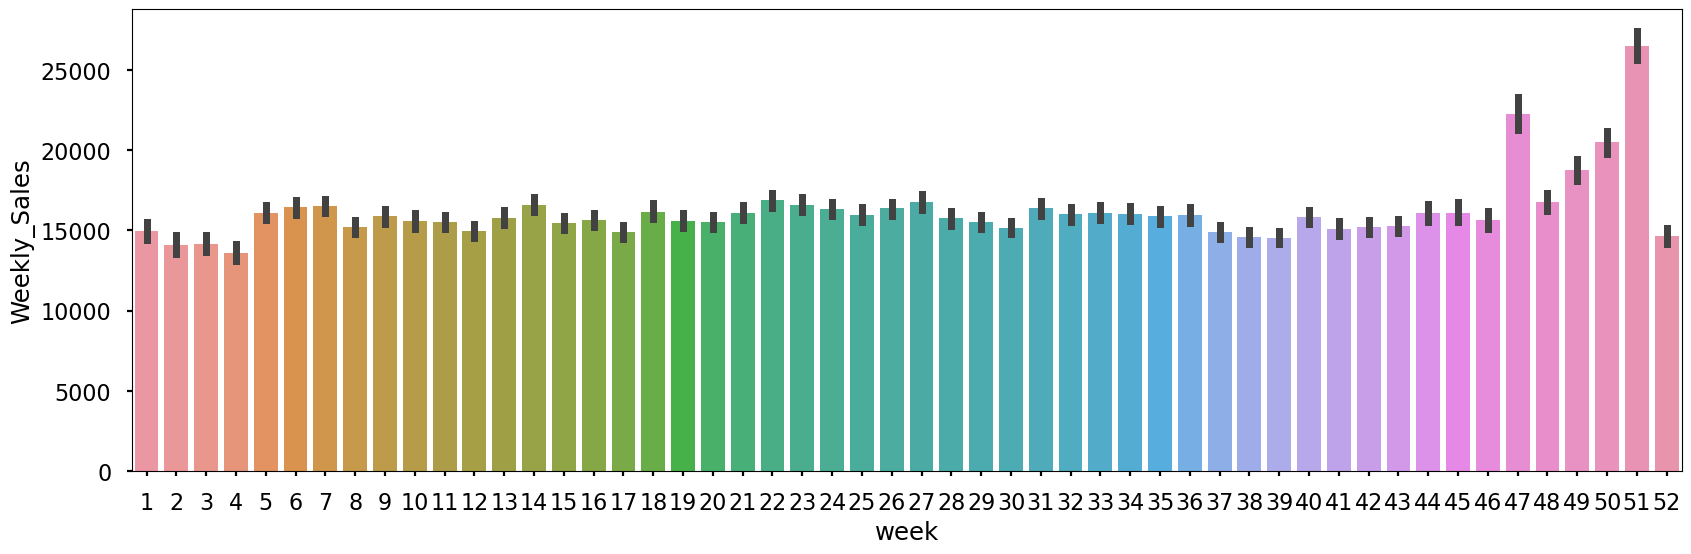

In [54]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From the graphs, it is seen that 51th week and 47th week have significantly higher than average

## Fuel Price, CPI, Unemployment, Temperature Effects

<Axes: xlabel='Fuel_Price'>

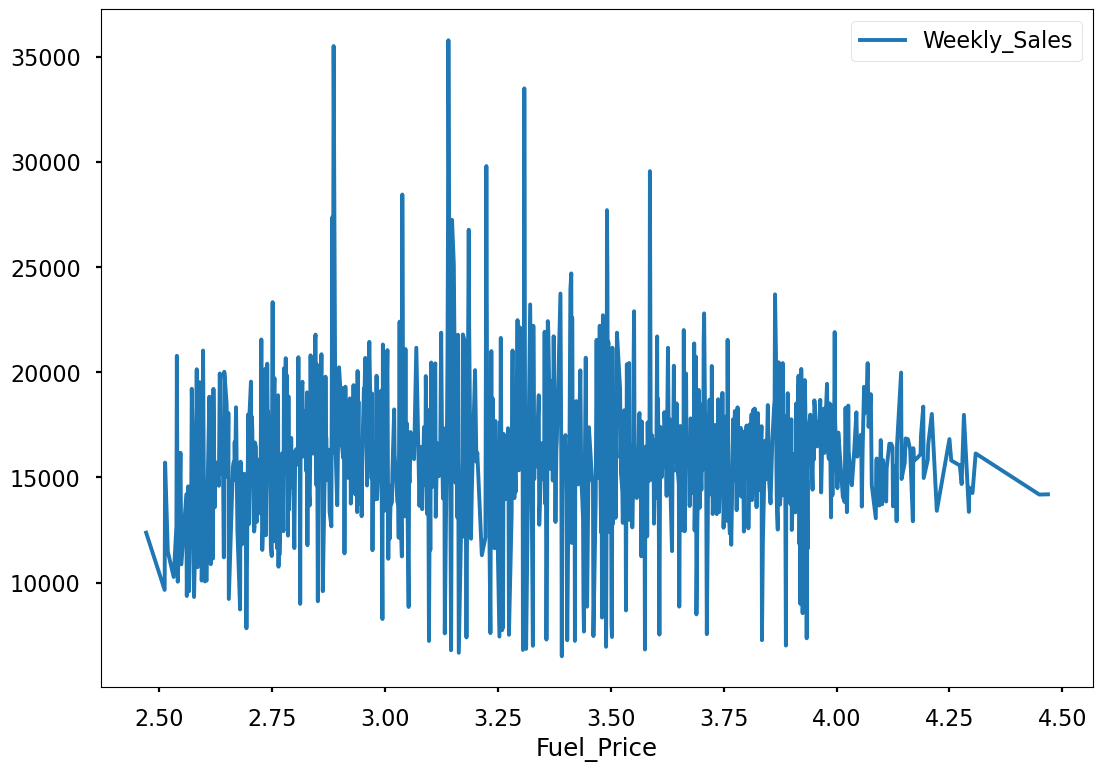

In [55]:
fuel_price = pd.pivot_table(df,values = 'Weekly_Sales',index='Fuel_Price')
fuel_price.plot()

<Axes: xlabel='Temperature'>

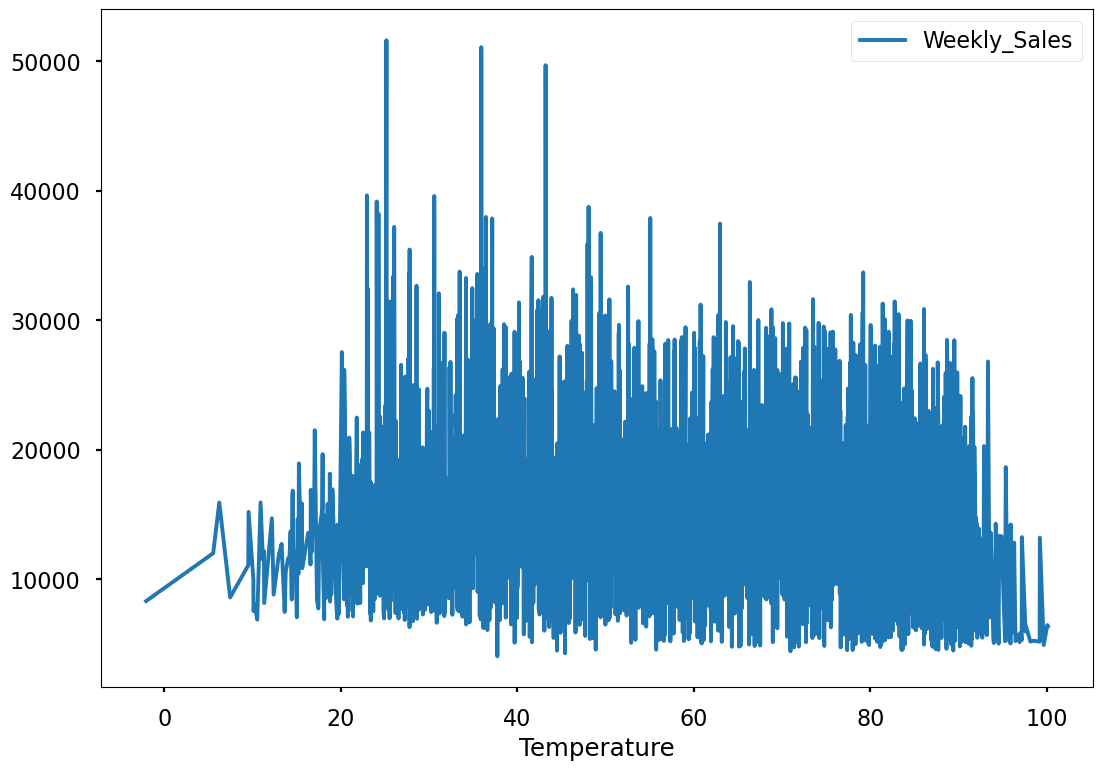

In [56]:
temp = pd.pivot_table(df,values='Weekly_Sales',index='Temperature')
temp.plot()

<Axes: xlabel='CPI'>

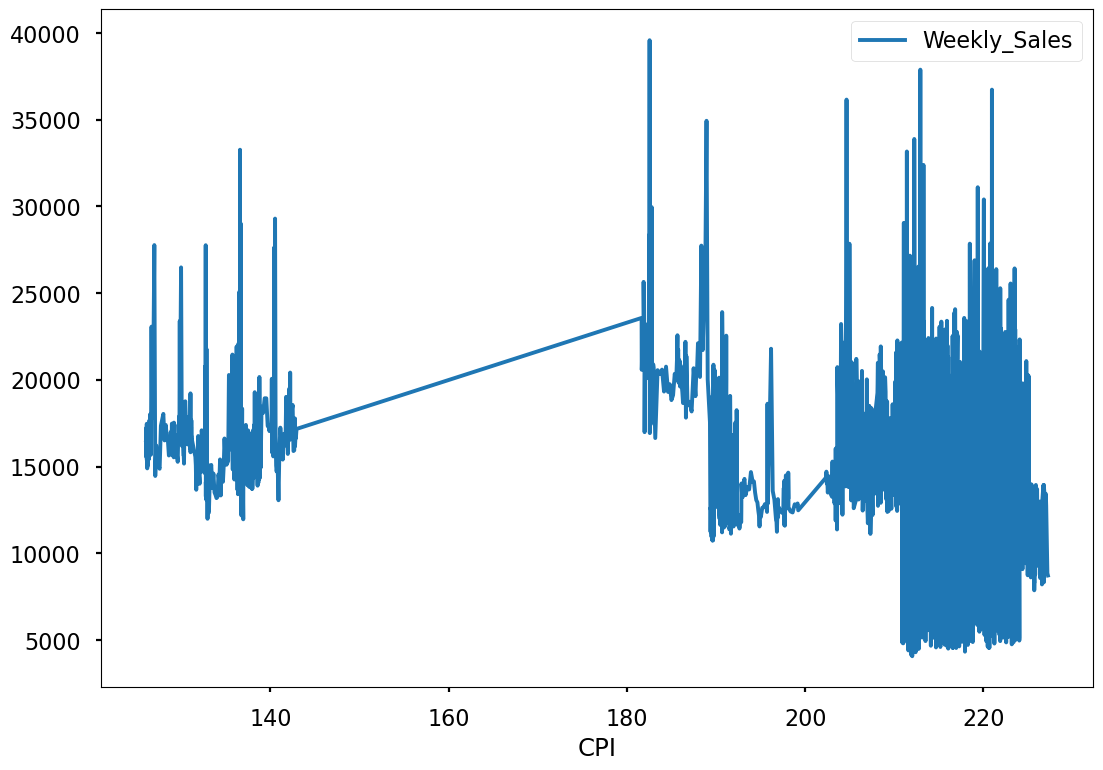

In [57]:
CPI = pd.pivot_table(df,values='Weekly_Sales',index='CPI')
CPI.plot()

<Axes: xlabel='Unemployment'>

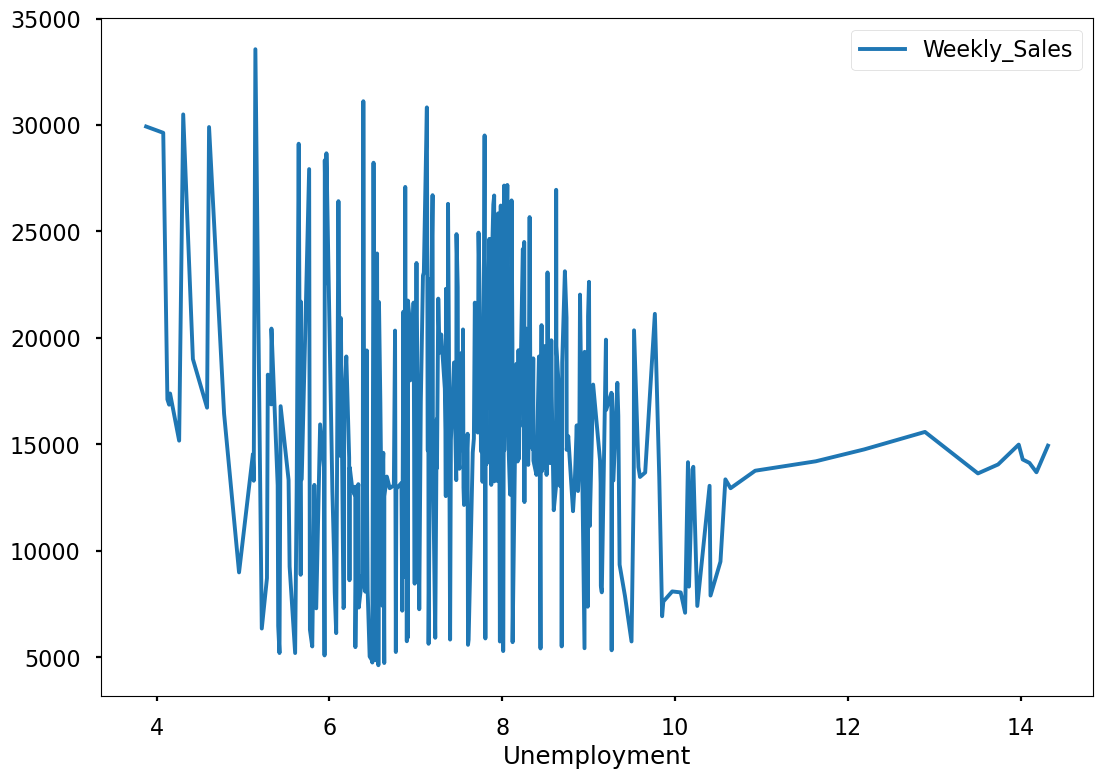

In [58]:
unemployment = pd.pivot_table(df,values='Weekly_Sales',index='Unemployment')
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price versus weekly sales. There is no data for CPI between 140-180 also

## Findings and Explorations

## Cleaning Process
- we choose rows which had higher than 0 weekly sales. Minus values are 0.3% of data -> drop them

## Explorations & Findings

- There are 45 stores and 81 department in data. Departments are not same in all stores
- Although department 72 has higher weekly sales values, on average department 92 is the best. It shows that some departments has higher values as seasonal like Thanksgiving. It is consistent when we look at top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday
- Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 on the first and second rank. It means some areas has higher seasonal sales
- As expected, holiday average sales are higher than normal dates

## First Trial with Random Forest

Generally, Random Forest Regressor gives good results when we tune it well. To find simple baseline model, I will use RandomForestRegressor in this notebook

In [59]:
pd.options.display.max_columns=100

In [60]:
df['Date'] = pd.to_datetime(df['Date'])

## Encoding the Data

For preprocessing our data, I will change holidays boolean values to 0-1 and replace type of the stores from A,B,C to 1,2,3

In [61]:
df_encoded= df.copy()

In [62]:
type_group={'A':1,'B':2,'C':3}
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [63]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int)

In [64]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int)

In [65]:
df_encoded['Christmas']=df_encoded['Christmas'].astype(bool).astype(int)

In [66]:
df_encoded['IsHoliday']=df_encoded['IsHoliday'].astype(bool).astype(int)

In [67]:
df_new = df_encoded.copy()

## Observation of Interactions between Features

Firstly, drop divided holiday columns from data and try without them. To keep encoded data safe, assign dataframe to new one

In [68]:
drop_col = ['Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True)

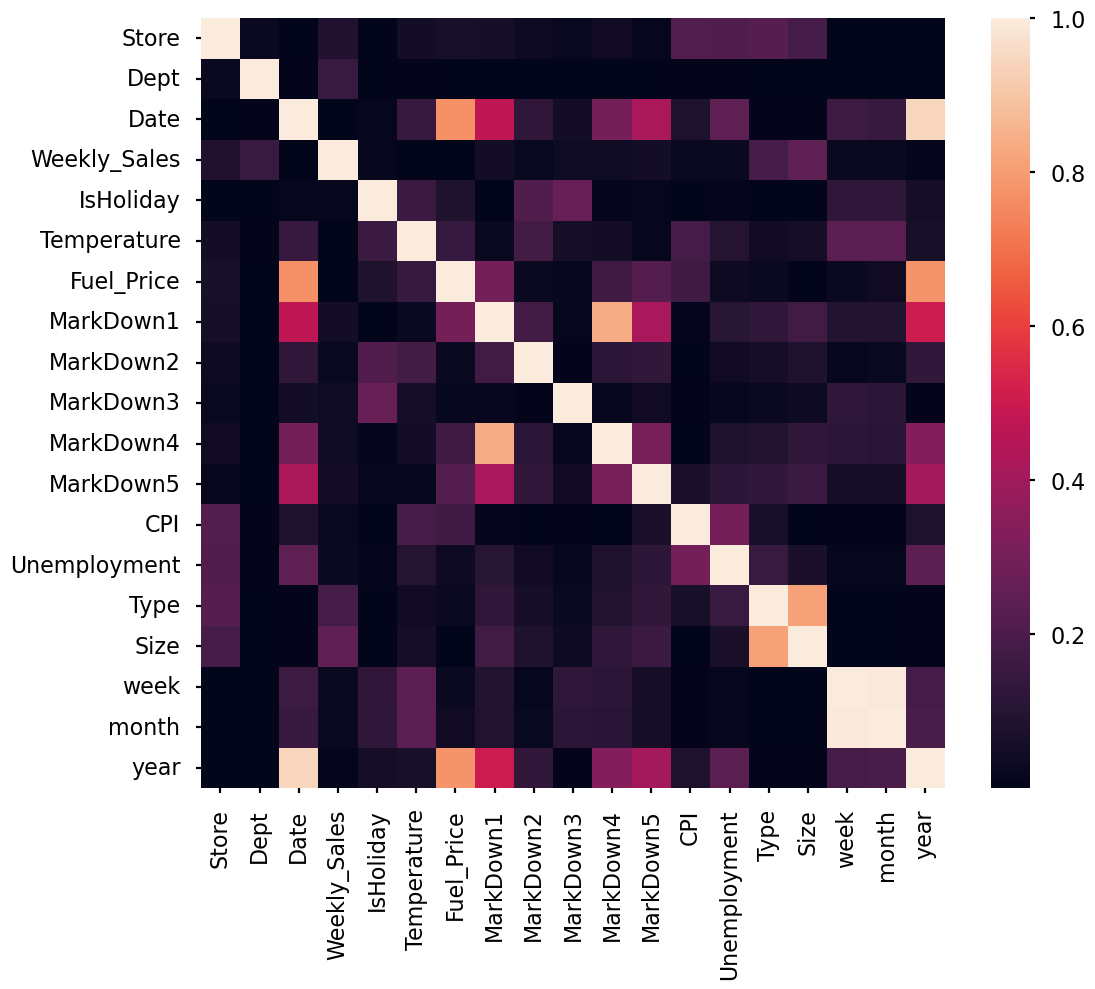

In [69]:
plt.figure(figsize =(12,10))
sns.heatmap(df_new.corr().abs())
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so we will drop them. Also, Markdown 4 and 5 highly correlated with Markdown . So we will drop them also. It can create multicollinearity problem so we will try without them

In [70]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

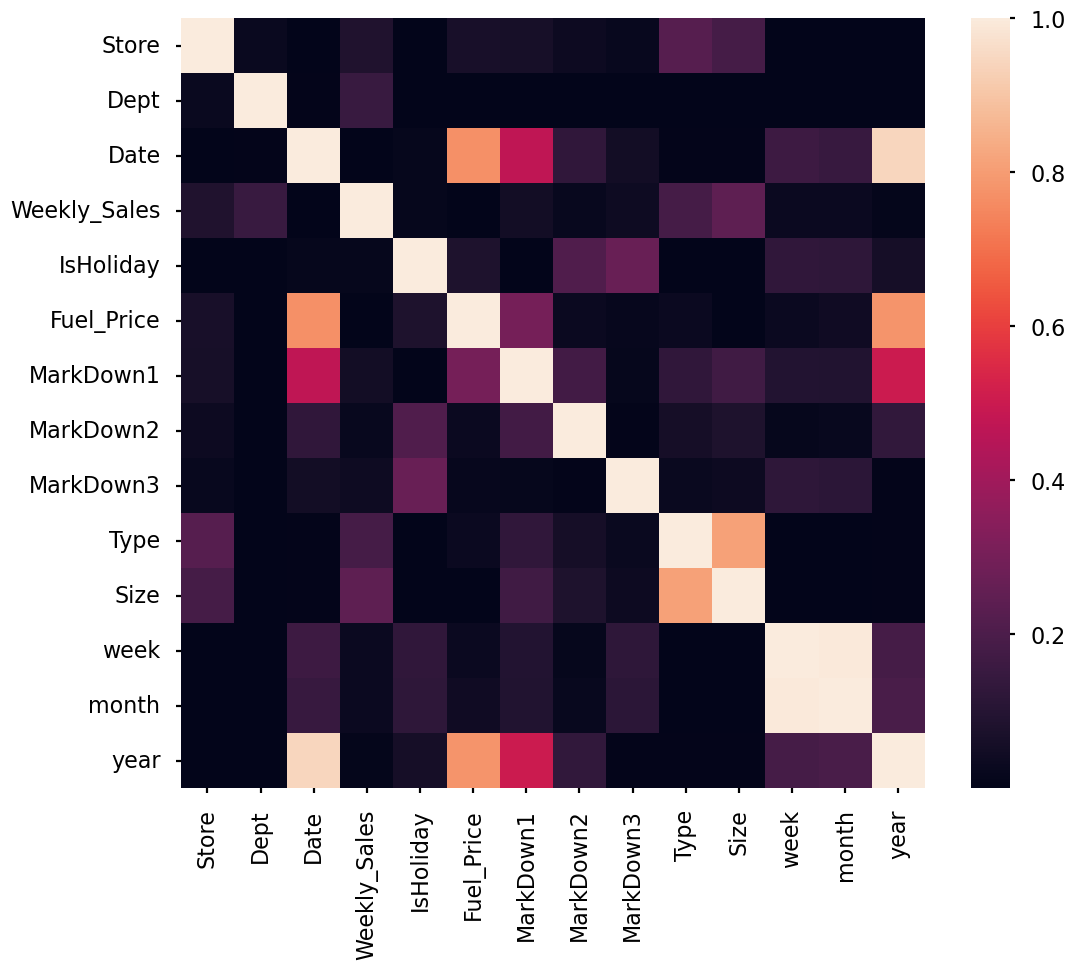

In [71]:
plt.figure(figsize = (12,10))
# To see the correlations without dropping columns
sns.heatmap(df_new.corr().abs())    
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [72]:
#sorting according to date
df_new = df_new.sort_values(by='Date', ascending=True) 

## Create Train-Test Splits

Our date column has continuous values so to keep the date features continue, we split data manually according to 70%

In [73]:
train_data = df_new[:int(0.7*len(df_new))]
test_data = df_new[int(0.7*len(df_new)):]

target = 'Weekly_Sales'
used_cols = [c for c in df_new.columns.to_list() if c not in [target]]

x_train = train_data[used_cols]
x_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [74]:
X = df_new[used_cols]

In [75]:
x_train = x_train.drop(['Date'],axis=1)
x_test= x_test.drop(['Date'],axis=1)

## Metric Definition Function

Use function to calculate weighed error

In [76]:
def wmae_test(test,pred):
    weights=x_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error=np.sum(weights*np.abs(test-pred),axis=0)/np.sum(weights)
    return error

## Random Forest Regressor

To tune regressor we can use regressor parameters manually.

In [77]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(x_train, y_train)

# predictions on train set
y_pred = pipe.predict(x_train)

# predictions on test set
y_pred_test = pipe.predict(x_test)

In [78]:
wmae_test(y_test, y_pred_test)

5680.1239911472085

For the first trial, my weighted error is around 5850.

## To see Feature Importance

In [79]:
#dropping date from column from X
X = X.drop(['Date'], axis=1)

Feature ranking:
1. feature 1 (0.733058)
2. feature 8 (0.109850)
3. feature 0 (0.055522)
4. feature 7 (0.037639)
5. feature 9 (0.021446)
6. feature 3 (0.018735)
7. feature 10 (0.008768)
8. feature 6 (0.005361)
9. feature 4 (0.003152)
10. feature 5 (0.002604)
11. feature 2 (0.002280)
12. feature 11 (0.001587)


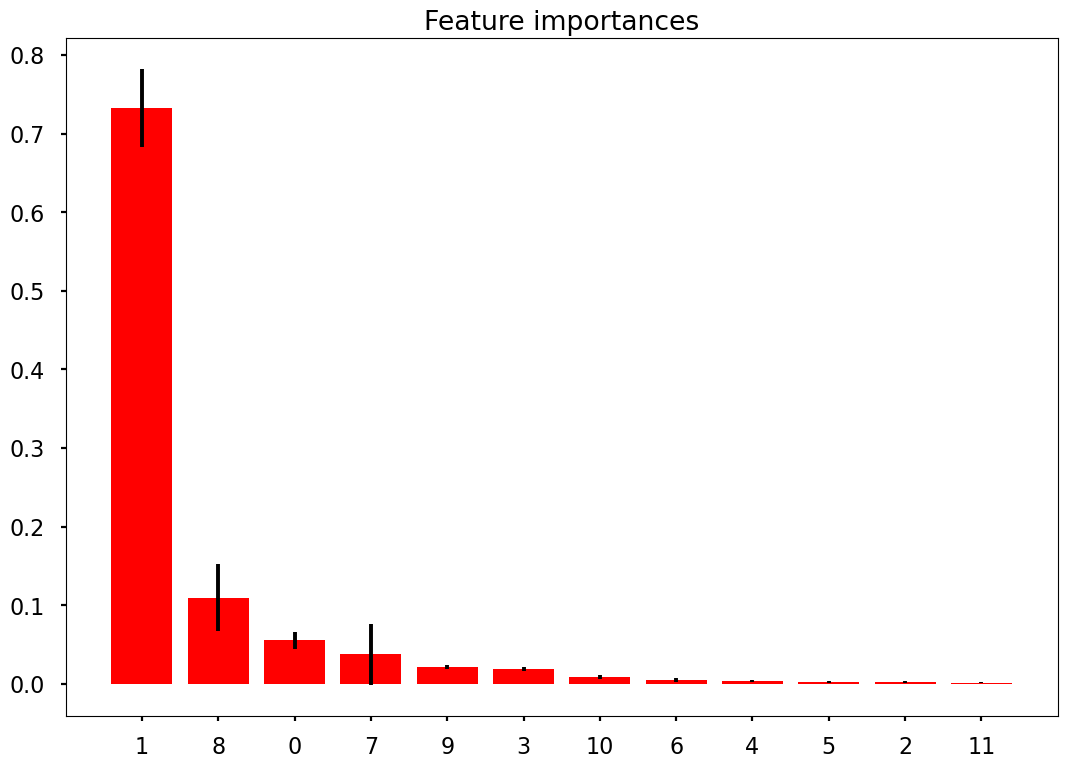

In [80]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [81]:
x1_train = x_train.drop(['month'],axis=1)
x1_test = x_test.drop(['month'],axis=1)

## Model without Month

In [82]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(x1_train, y_train)

# predictions on train set
y_pred = pipe.predict(x1_train)

# predictions on test set
y_pred_test = pipe.predict(x1_test)

In [83]:
wmae_test(y_test, y_pred_test)

5596.9867246903195

## Model with whole data

In [84]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [85]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [86]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [87]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [88]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [89]:
wmae_test(y_test_enc, y_pred_test_enc)

2646.3942503605826

We found better results with whole data so that our model can learn from columns dropped before

## Feature Importance for Whole Encoded Dataset

Feature ranking:
1. feature 1 (0.739246)
2. feature 13 (0.081681)
3. feature 12 (0.038799)
4. feature 10 (0.030148)
5. feature 0 (0.029019)
6. feature 11 (0.018628)
7. feature 17 (0.012737)
8. feature 3 (0.011881)
9. feature 4 (0.009842)
10. feature 18 (0.005382)
11. feature 7 (0.004904)
12. feature 9 (0.003973)
13. feature 5 (0.003640)
14. feature 8 (0.003388)
15. feature 6 (0.002468)
16. feature 15 (0.001173)
17. feature 19 (0.001081)
18. feature 2 (0.001059)
19. feature 16 (0.000641)
20. feature 14 (0.000310)


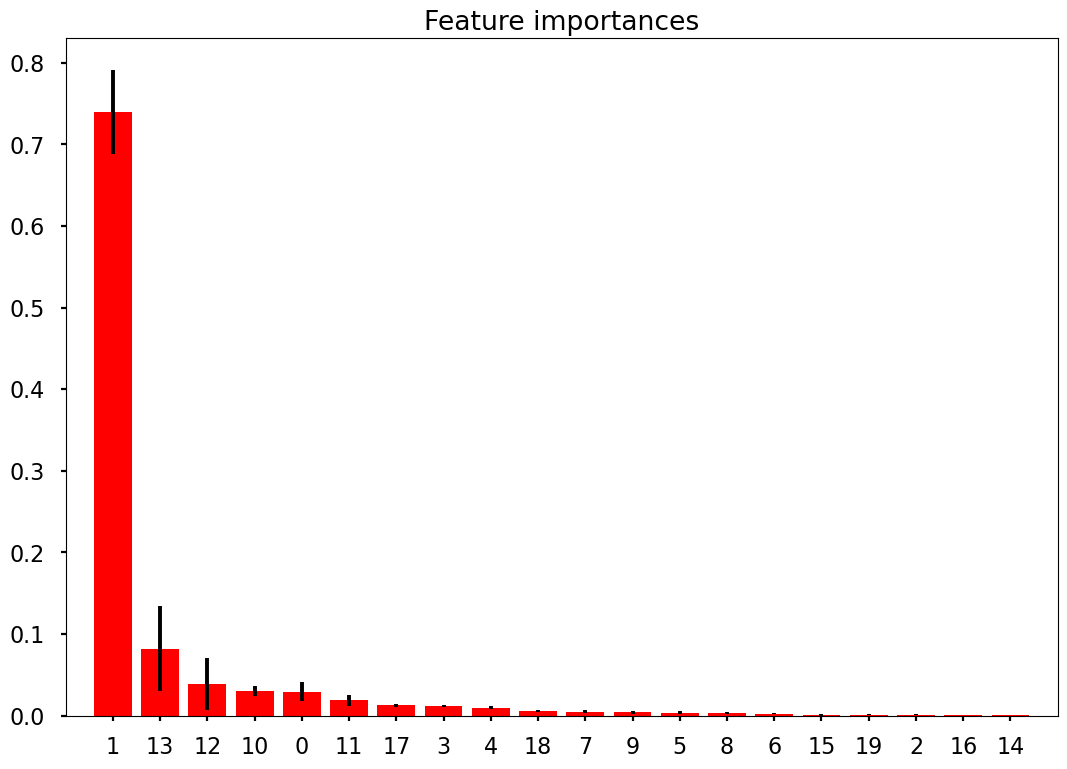

In [90]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

In [91]:
# taking copy of encoded data to keep it without change
df_encoded_new = df_encoded.copy()
df_encoded_new.drop(drop_col, axis=1, inplace=True)

## Model According to Feature Importance

In [92]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [93]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [94]:
pipe.score(X_test_enc1,y_test_enc1)

0.6954788490038133

In [95]:
wmae_test(y_test_enc1, y_pred_test_enc)

2234.3756513894436

## Model with Dropping Month column

In [96]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [97]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [98]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [99]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [100]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [101]:
pipe.score(X_test_enc2,y_test_enc2)

0.7083116411645769

In [102]:
wmae_test(y_test_enc2, y_pred_test_enc)

2200.7409344685225

It did give better than before

## Time Series Model

In [103]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,False,False,False,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,False,False,False,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,False,False,False,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,False,False,False,9,3,2010


In [104]:
df['Date'] = pd.to_datetime(df['Date'])

In [105]:
df.set_index('Date',inplace=True)

## Plotting Sales

In [106]:
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

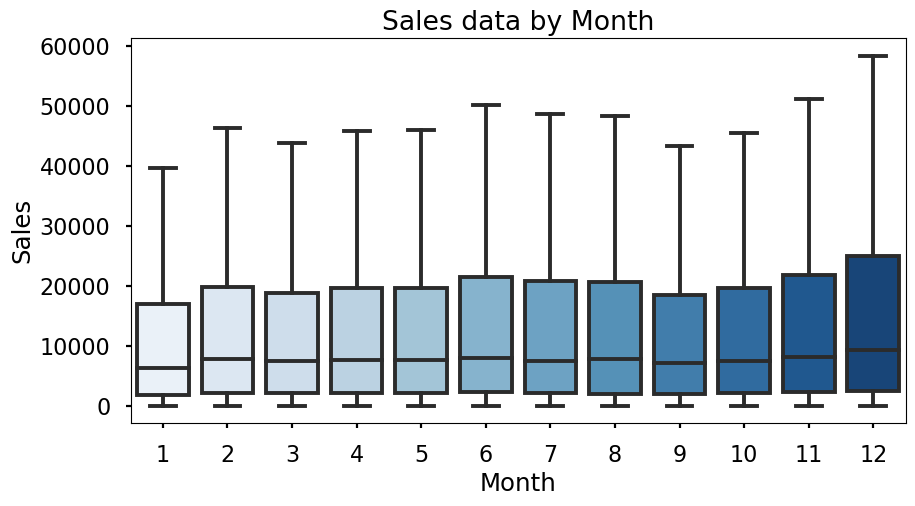

In [107]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df.loc[(df.index >'2011-01-01') & (df.index<'2011-12-31')], x='Month', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Month')
plt.ylabel('Sales')
plt.show()

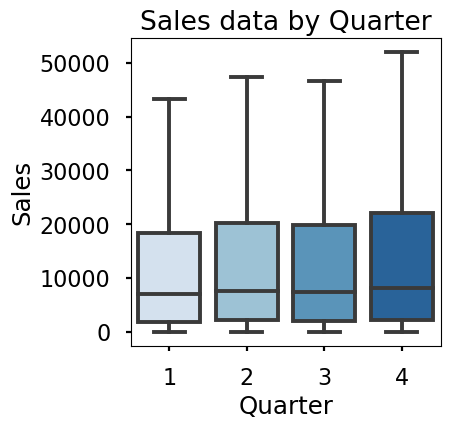

In [108]:
plt.figure(figsize=(4,4))
sns.boxplot(data=df.loc[(df.index >'2011-01-01') & (df.index<'2011-12-31')], x='Quarter', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Quarter')
plt.ylabel('Sales')
plt.show()

## Predicting overall sales per day using SARIMA model

In [109]:
cum_pdf = df['Weekly_Sales'].groupby('Date').sum().to_frame(name='Weekly_Sales')

In [110]:
train = cum_pdf.loc[cum_pdf.index < '2012-05-01']
test = cum_pdf.loc[cum_pdf.index >= '2012-05-01']

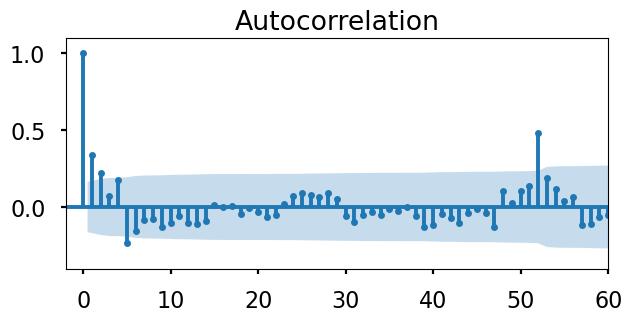

In [111]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(7,3))
acf_plot = plot_acf(cum_pdf.Weekly_Sales, lags=100, ax=ax)
plt.ylim(-0.4, 1.1)
plt.xlim(-2,60)
plt.show()

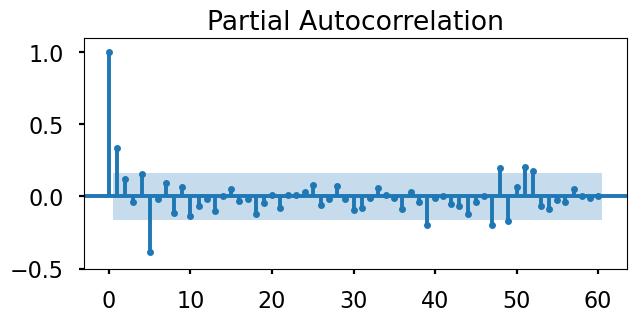

In [112]:
fig, ax = plt.subplots(figsize=(7,3))
pacf_plot = plot_pacf(cum_pdf.Weekly_Sales, lags=60, ax=ax)
plt.ylim(-0.5, 1.1)
plt.show()

Based on PACF, we should start with Auto Regressive (AR) model with lags 1,2,5,52

**AD-Fuller Test**

In [113]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(cum_pdf.Weekly_Sales)   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.908397717797436
p-value: 2.6746067888257997e-07


As the p-value is less than 0.05 and ADF statistic is a negative number
The Time series is Stationary

In [116]:
# The model with the best p and q found from pervious step
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(52, 0, 5))
# Fit model
results = model.fit()
# Assign residuals to variable
residuals = results.resid

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           58     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81751D+02    |proj g|=  9.12563D+02


 This problem is unconstrained.



At iterate    5    f=  2.29253D+01    |proj g|=  6.33581D+00

At iterate   10    f=  1.68719D+01    |proj g|=  1.35813D+00

At iterate   15    f=  1.66190D+01    |proj g|=  4.31318D-01

At iterate   20    f=  1.65875D+01    |proj g|=  1.61225D-01

At iterate   25    f=  1.65559D+01    |proj g|=  1.20056D-01

At iterate   30    f=  1.64927D+01    |proj g|=  8.92687D-01

At iterate   35    f=  1.64044D+01    |proj g|=  2.22027D-01

At iterate   40    f=  1.63808D+01    |proj g|=  1.02694D-01

At iterate   45    f=  1.63712D+01    |proj g|=  7.50769D-02

At iterate   50    f=  1.63524D+01    |proj g|=  1.31631D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [118]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  117
Model:              SARIMAX(52, 0, 5)   Log Likelihood               -1913.236
Date:                Tue, 27 Feb 2024   AIC                           3942.473
Time:                        19:11:17   BIC                           4102.679
Sample:                    02-05-2010   HQIC                          4007.515
                         - 04-27-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0207      0.134     -0.154      0.877      -0.284       0.242
ar.L2          0.0689      0.119      0.579      0.563      -0.164       0.302
ar.L3         -0.0838      0.106     -0.793      0.428      -0.291       0.123
ar.L4         -0.0063      0.084     -0.074      0.941      -0.172       0.159
ar.L5         -0.0033      0.099     -0.033      0.974      -0.197       0.190
ar.L6         -0.1009      0.120     -0.841      0.400      -0.336       0.134
ar.L7          0.1075      0.089      1.209      0.227      -0.067       0.282
ar.L8         -0.0436      0.090     -0.483      0.629      -0.220       0.133
ar.L9         -0.0288      0.088     -0.329      0.742      -0.200       0.143
ar.L10         0.0509      0.100      0.509      0.611      -0.145       0.247
ar.L11        -0.0795      0.106     -0.752      0.452      -0.287       0.128
ar.L12         0.0849      0.082      1.035      0.301      -0.076       0.246
ar.L13        -0.0274      0.083     -0.332      0.740      -0.189       0.134
ar.L14        -0.0954      0.101     -0.945      0.345      -0.293       0.102
ar.L15         0.0992      0.095      1.049      0.294      -0.086       0.284
ar.L16         0.0052      0.074      0.071      0.944      -0.140       0.150
ar.L17         0.0544      0.069      0.785      0.433      -0.081       0.190
ar.L18         0.0208      0.076      0.275      0.784      -0.128       0.170
ar.L19        -0.0345      0.092     -0.376      0.707      -0.214       0.145
ar.L20         0.0463      0.075      0.613      0.540      -0.102       0.194
ar.L21        -0.0340      0.081     -0.422      0.673      -0.192       0.124
ar.L22         0.0051      0.067      0.076      0.939      -0.127       0.137
ar.L23         0.0185      0.095      0.194      0.846      -0.168       0.205
ar.L24        -0.0183      0.098     -0.186      0.852      -0.211       0.175
ar.L25         0.0853      0.083      1.021      0.307      -0.078       0.249
ar.L26        -0.0143      0.084     -0.170      0.865      -0.179       0.150
ar.L27         0.0033      0.100      0.033      0.974      -0.192       0.199
ar.L28         0.0629      0.111      0.569      0.569      -0.154       0.279
ar.L29        -0.0152      0.082     -0.185      0.853      -0.176       0.146
ar.L30         0.0571      0.071      0.807      0.420      -0.082       0.196
ar.L31        -0.0256      0.104     -0.247      0.805      -0.229       0.178
ar.L32        -0.0033      0.110     -0.030      0.976      -0.219       0.213
ar.L33         0.0726      0.077      0.940      0.347      -0.079       0.224
ar.L34        -0.0648      0.063     -1.025      0.305      -0.189       0.059
ar.L35         0.0271      0.085      0.317      0.751      -0.140       0.195
ar.L36        -0.0129      0.102     -0.127      0.899      -0.213       0.187
ar.L37        -0.0628      0.090     -0.696      0.487      -0.240       0.114
ar.L38         0.1568      0.070      2.241      0.025       0.020       0.294
ar

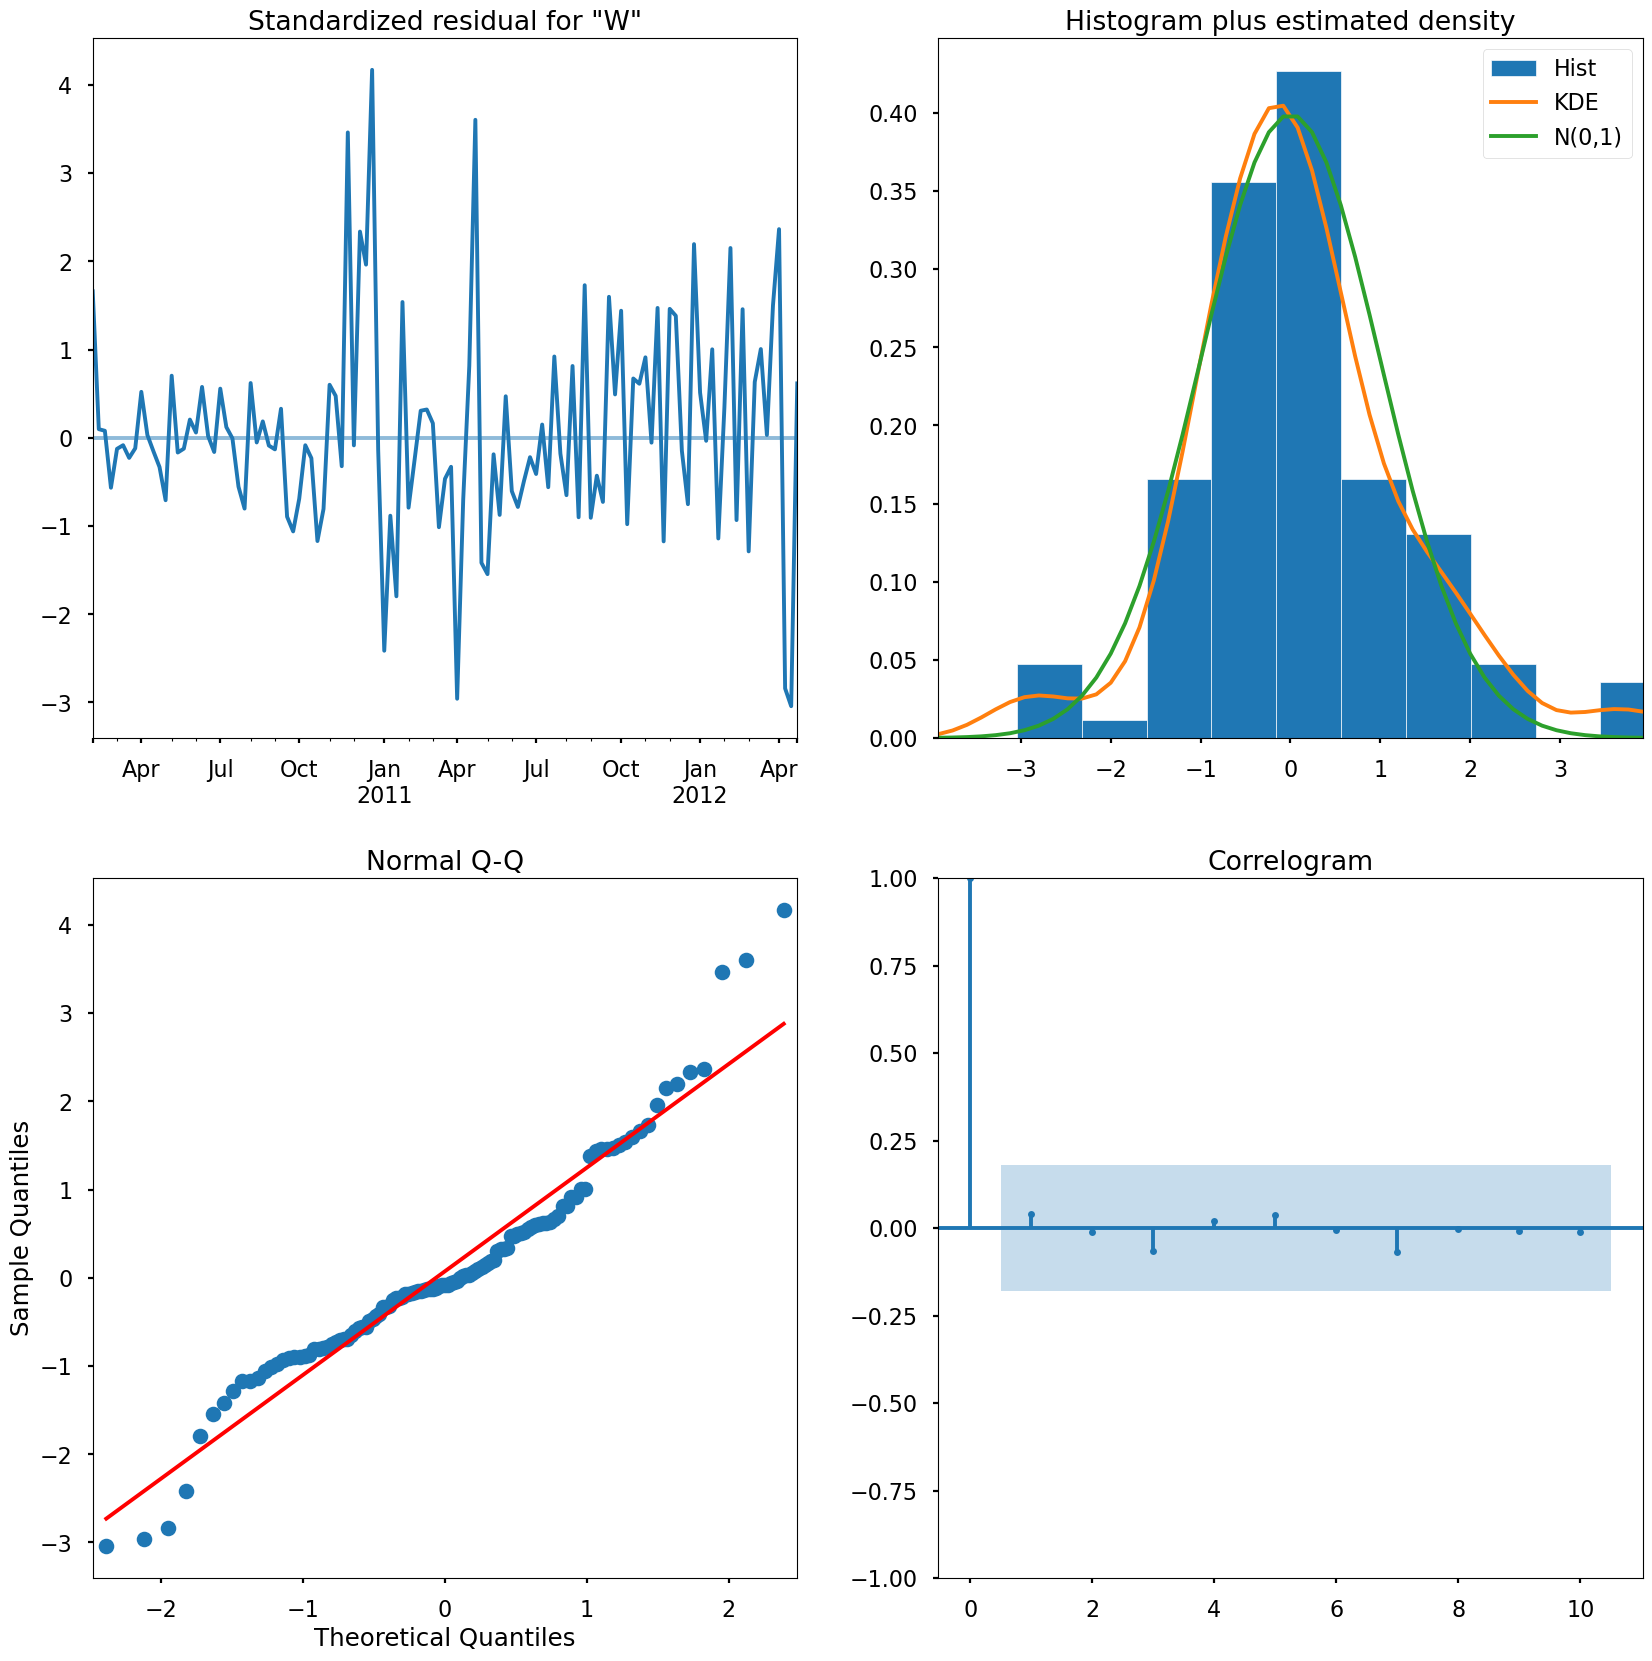

In [122]:
results.plot_diagnostics (figsize=(20,20))
plt.show()

**Standardized residuals plot**: The top left plot shows one-step-ahead standardized residuals. If our model is working correctly, there should be no obvious pattern in the residuals. This is shown here in this case.

**Histogram plus estimated density plot**: This plot shows the distribution of the residuals. The histogram shows us the measured distribution; the orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same. Here there are little differences between them, which indicate that our model is doing great.

**Normal Q-Q plot**: The Q-Q plot compare the distribution of the residuals to the normal distribution. If the distribution of the residuals is normal, then all the points should lie along the red line, except for some values at the end.

**Correlogram plot**: The correlogram plot is the ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant (within the blue shades). If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model.

**PREDICTION**

In [124]:
#get the predictions and residuals
predictions = results.forecast(len(test))
predictions = pd.Series(predictions, index=test.index).to_frame(name='Weekly_Sales')
residuals = test - predictions

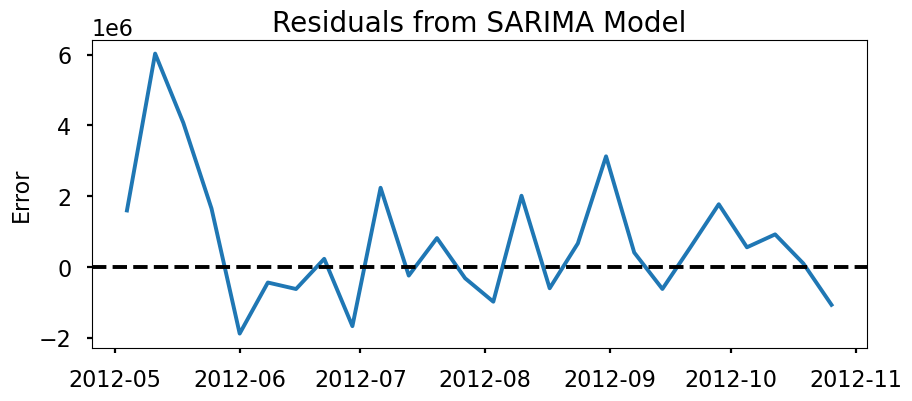

In [125]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title( 'Residuals from SARIMA Model' ,fontsize=20)
plt.ylabel( 'Error', fontsize=16)
plt.show()

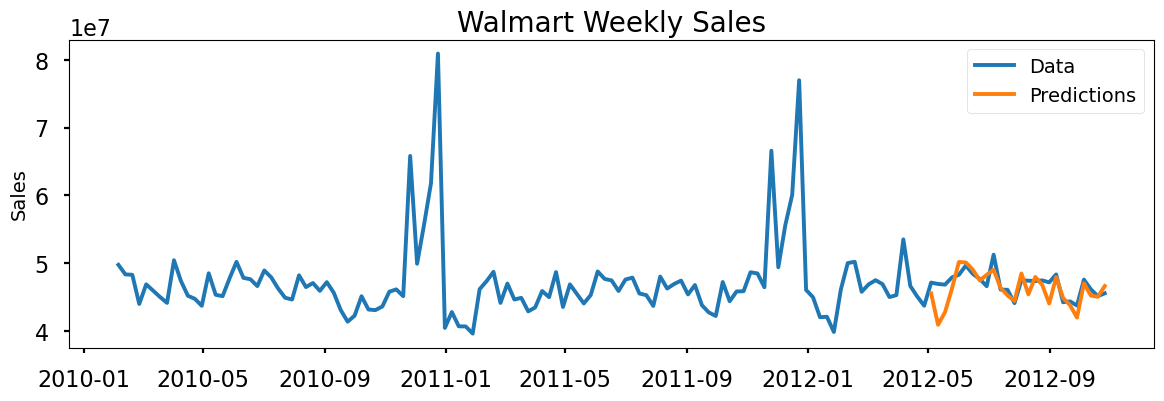

In [131]:
plt.figure(figsize=(14,4))
plt.plot(cum_pdf)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=14)

plt.title('Walmart Weekly Sales', fontsize=20)
plt.ylabel('Sales', fontsize=14)
plt.show()

In [136]:
print('MAPE: ', round(np.mean(abs(residuals/test)),4))
# The mean absolute error
mae = np.mean(np.abs(residuals))
print("Mean Absolute Error: ", mae)
print('Root Mean Squared Error: ', round(np.sqrt(np.mean(residuals**2)),2))


MAPE:  0.0288
Mean Absolute Error:  1354427.1989075588
Root Mean Squared Error:  1890560.44


In [137]:
predictions

,Weekly_Sales
Date,
2012-05-04,4.553040e+07
2012-05-11,4.089755e+07
2012-05-18,4.275312e+07
2012-05-25,4.624267e+07
2012-06-01,5.016875e+07
2012-06-08,5.009462e+07
2012-06-15,4.903923e+07
2012-06-22,4.744135e+07
2012-06-29,4.827401e+07
